In the context of this project, we are using MySQL to perform queries for further data summarization and visualization. Our dataset is small enough that we feel comfortable keeping it in CSV form for other analytics.

In [1]:
import mysql.connector
from mysql.connector import errorcode
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt

### Database Setup
This portion populates a MySQL server with values from a pandas DataFrame.

In [2]:
# Run this the first time
# !pip install pymysql

In [3]:
# Configure to your own user and password
mysql_user = 'root'
mysql_pw = ''
mysql_host = 'localhost'

engine = sqlalchemy.create_engine(f"mysql+pymysql://{mysql_user}:{mysql_pw}@{mysql_host}")
conn = engine.connect()
conn

In [4]:
data = pd.read_csv("bechdel_analysis_data_cleaned.csv", float_precision=None)

In [5]:
def execute_dml(dml_string):
    try:
        conn.execute(dml_string)
    except mysql.connector.Error as err:
        print("Error:", err)
        
def execute_query(query_string):
    try:
        res = conn.execute(query_string)
        return res.fetchall()
    except mysql.connector.Error as err:
        print("Error:", err)

def create_db():
    drop_existing_db = "DROP DATABASE IF EXISTS bechdel;"
    create_bechdel = "CREATE DATABASE bechdel;"
    use_bechdel = "USE bechdel;"
    try:
        execute_dml(drop_existing_db)
        execute_dml(create_bechdel)
        execute_dml(use_bechdel)
    except mysql.connector.Error as err:
        print("Error:", err)
        
def populate_db():
    general_data = data.drop(['genres', 'prod_comps'], axis=1)
    general_data.to_sql('general', conn, if_exists='replace', dtype={
        'year': sqlalchemy.types.INTEGER(),
        'imdb': sqlalchemy.types.VARCHAR(length=12),
        'title': sqlalchemy.types.VARCHAR(length=255),
        'clean_test': sqlalchemy.types.VARCHAR(length=20),
        'binary_passed': sqlalchemy.types.INTEGER(),
        'budget_2013$': sqlalchemy.types.BIGINT(),
        'domgross_2013$': sqlalchemy.types.BIGINT(),
        'intgross_2013$': sqlalchemy.types.BIGINT(),
        'overview': sqlalchemy.types.TEXT(),
        'perc_women_producers': sqlalchemy.types.FLOAT(),
        'perc_women_directors': sqlalchemy.types.FLOAT()
    })
    
    # Convert into workable list type before using .explode()
    genre_data = data[['imdb', 'genres']]
    for i in range(genre_data.count()[0]):
        genre_data.iloc[i].genres = genre_data.iloc[i].genres.strip('[]').replace('\'', "").split(', ')
    genre_data = genre_data.explode('genres')
    genre_data.to_sql('genre', conn, if_exists='replace', dtype={
        'imdb': sqlalchemy.types.VARCHAR(length=12),
        'genre': sqlalchemy.types.VARCHAR(length=20)
    })
    
    prod_data = data[['imdb', 'prod_comps']]
    for i in range(prod_data.count()[0]):
        prod_data.iloc[i].prod_comps = prod_data.iloc[i].prod_comps.strip('[]').replace('\'', "").split(', ')
    prod_data = prod_data.explode('prod_comps')
    prod_data.to_sql('production_company', conn, if_exists='replace', dtype={
        'imdb': sqlalchemy.types.VARCHAR(length=12),
        'genre': sqlalchemy.types.VARCHAR(length=50)
    })
    execute_dml('ALTER TABLE general ADD PRIMARY KEY (imdb);')
    execute_dml('ALTER TABLE genre ADD FOREIGN KEY (imdb) REFERENCES general(imdb);')
    execute_dml('ALTER TABLE production_company ADD FOREIGN KEY (imdb) REFERENCES general(imdb);')

In [6]:
create_db()
populate_db()

print(execute_query("DESC general"), '\n');
print(execute_query("DESC genre"), '\n');
print(execute_query("DESC production_company"));

[('index', 'bigint', 'YES', 'MUL', None, ''), ('year', 'int', 'YES', '', None, ''), ('imdb', 'varchar(12)', 'NO', 'PRI', None, ''), ('title', 'varchar(255)', 'YES', '', None, ''), ('clean_test', 'varchar(20)', 'YES', '', None, ''), ('budget_2013$', 'bigint', 'YES', '', None, ''), ('binary_PASS', 'bigint', 'YES', '', None, ''), ('domgross_2013$', 'bigint', 'YES', '', None, ''), ('overview', 'text', 'YES', '', None, ''), ('perc_women_producers', 'float', 'YES', '', None, ''), ('perc_women_directors', 'float', 'YES', '', None, '')] 

[('index', 'bigint', 'YES', 'MUL', None, ''), ('imdb', 'varchar(12)', 'YES', 'MUL', None, ''), ('genres', 'text', 'YES', '', None, '')] 

[('index', 'bigint', 'YES', 'MUL', None, ''), ('imdb', 'varchar(12)', 'YES', 'MUL', None, ''), ('prod_comps', 'text', 'YES', '', None, '')]


### Querying the Database

#### Overall Financial Analysis

In [7]:
print('Avg budget, domestic gross sales, and internationaly gross sales for movies that passed')

res = execute_query("""
    SELECT CONCAT('$', FORMAT(avg(budget_2013$), 2)),
           CONCAT('$', FORMAT(avg(domgross_2013$), 2))
        FROM general
    WHERE binary_PASS = 1;
"""
)
print(res[0])

print('\nAvg budget, domestic gross sales, and internationaly gross sales for movies that failed')
res = execute_query("""
    SELECT CONCAT('$', FORMAT(avg(budget_2013$), 2)),
           CONCAT('$', FORMAT(avg(domgross_2013$), 2))
        FROM general
    WHERE binary_PASS = 0;
"""
)
print(res[0])

Avg budget, domestic gross sales, and internationaly gross sales for movies that passed
('$47,513,235.72', '$81,433,835.68')

Avg budget, domestic gross sales, and internationaly gross sales for movies that failed
('$63,920,870.91', '$109,101,318.80')


In [8]:
res = execute_query("""
    SELECT title,
           domgross_2013$,
           binary_PASS
    FROM general g
    ORDER BY domgross_2013$ DESC
    LIMIT 50;
""")
highest_sales = pd.DataFrame(res)
print("\nResults for 50 highest selling movies in the dataset")
highest_sales


Results for 50 highest selling movies in the dataset


,title,domgross_2013$,binary_PASS
0,Star Wars,1771682790,0
1,Jaws,1125306085,0
2,The Exorcist,1074306128,1
3,E.T.: The Extra-Terrestrial,1050038377,0
4,Titanic,955890356,1
5,The Sting,837011132,0
6,Avatar,825707158,0
7,Star Wars: Episode V - The Empire Strikes Back,820821721,0
8,The Godfather,752051643,0
9,Star Wars: Episode VI - Return of the Jedi,723340482,0


In [9]:
res = execute_query("""
    SELECT title,
           budget_2013$,
           binary_PASS
    FROM general g
    ORDER BY budget_2013$ DESC
    LIMIT 50;
""")
highest_budget = pd.DataFrame(res)
print("\nResults for 50 highest budget movies in the dataset")
highest_budget


Results for 50 highest budget movies in the dataset


,title,budget_2013$,binary_PASS
0,Avatar,461435929,0
1,Pirates of the Caribbean: At World&#39;s End,337063045,1
2,Shaft,305063707,0
3,Titanic,290247625,1
4,John Carter,279025606,1
5,The Dark Knight Rises,279025606,0
6,Tangled,277740279,1
7,The Lone Ranger,275000000,0
8,Harry Potter and the Half-Blood Prince,271432899,1
9,Superman Returns,268144752,0


#### Production Company Analysis

In [10]:
res = execute_query("""
    SELECT COUNT(*) AS movie_count,
           prod_comps,
           SUM(CASE WHEN g.binary_PASS = 1 THEN 1 ELSE 0 END) / COUNT(*) AS perc_passing
    FROM production_company pc
    JOIN general g ON pc.imdb = g.imdb
    GROUP BY prod_comps
    ORDER BY movie_count DESC
    LIMIT 100;
""")
prod_passing = pd.DataFrame(res)
print("\nPassing percentages for most popular production companies in dataset\n")
prod_passing


Passing percentages for most popular production companies in dataset



,movie_count,prod_comps,perc_passing
0,171,Warner Bros. Pictures,0.3567
1,165,Universal Pictures,0.4000
2,152,Columbia Pictures,0.4474
3,128,Paramount,0.3906
4,122,20th Century Fox,0.3689
...,...,...,...
95,8,Endgame Entertainment,0.6250
96,8,The Mark Gordon Company,0.3750
97,8,Lions Gate Films,0.5000
98,8,Orion Pictures,0.2500


Text(0, 0.5, 'Percent of Movies Passing Bechdel Test')

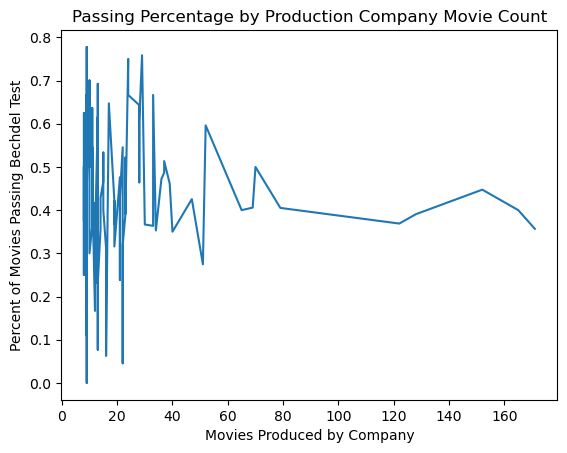

In [11]:
plt.plot(prod_passing.movie_count, prod_passing.perc_passing)
plt.title("Passing Percentage by Production Company Movie Count")
plt.xlabel("Movies Produced by Company")
plt.ylabel("Percent of Movies Passing Bechdel Test")

In [12]:
res = execute_query("""
    SELECT COUNT(*) AS movie_count,
           prod_comps,
           SUM(CASE WHEN g.binary_PASS = 1 THEN 1 ELSE 0 END) / COUNT(*) AS perc_passing
    FROM production_company pc
    JOIN general g ON pc.imdb = g.imdb
    GROUP BY prod_comps
    HAVING perc_passing = 1
    ORDER BY movie_count DESC;
""")
prod_passing = pd.DataFrame(res)
print("Production companies with 100% pass rate, by movie count\n")
prod_passing

Production companies with 100% pass rate, by movie count



,movie_count,prod_comps,perc_passing
0,6,Fortis Films,1.0000
1,5,Thin Man Films,1.0000
2,4,Offspring Entertainment,1.0000
3,4,HBO Films,1.0000
4,4,Craven-Maddalena Films,1.0000
...,...,...,...
817,1,August Films,1.0000
818,1,Film Funding Ltd. of Canada,1.0000
819,1,Vision IV,1.0000
820,1,Hoya Productions,1.0000


#### Genre Analysis

In [13]:
res = execute_query("""
    SELECT COUNT(*) AS movie_count,
           genres,
           SUM(CASE WHEN g.binary_PASS = 1 THEN 1 ELSE 0 END) / COUNT(*) AS perc_passing
    FROM genre gn
    JOIN general g ON gn.imdb = g.imdb
    GROUP BY genres
    ORDER BY movie_count DESC;
""")
genre_passing = pd.DataFrame(res)
print("Passing percentages by genre\n")
genre_passing.sort_values(by=['perc_passing'], ascending=False)

Passing percentages by genre



,movie_count,genres,perc_passing
5,321,Romance,0.6012
10,193,Horror,0.5959
15,50,Music,0.5800
1,637,Comedy,0.4835
0,764,Drama,0.4830
11,152,Mystery,0.4737
9,199,Family,0.4724
13,70,History,0.4714
8,233,Fantasy,0.4378
3,461,Thriller,0.3774


#### Clean_test Analysis
Note that only values of 'ok' indicate a pass in the binary_PASS column

In [14]:
res = execute_query("""
    SELECT COUNT(*) AS movie_count,
           clean_test
    FROM general g
    GROUP BY clean_test
    ORDER BY movie_count DESC;
""")
clean_test_freq = pd.DataFrame(res)
print("Frequencies for clean_test classifications\n")
clean_test_freq.sort_values(by=['movie_count'], ascending=False)

Frequencies for clean_test classifications



,movie_count,clean_test
0,767,ok
1,502,notalk
2,188,men
3,137,dubious
4,136,nowomen
